# **Classificação de extinção de incêndio com ondas sonoras baseada no tamanho das chamas e nas configurações do dispositivo emissor das ondas**

**Dataset:** https://www.kaggle.com/datasets/muratkokludataset/acoustic-extinguisher-fire-dataset

Essa base de dados é o resultado de experimentos conduzidos para determinar o estado de extinção de chamas de combustível usando um sistema de extinção de incêndio por ondas sonoras. O objetivo é prever se uma chama será extinta ou não com base em várias características relacionadas à configuração dos dispositivos emissores das ondas e às condições experimentais.

- O sistema inclui quatro subwoofers (alto-falante que reproduz frequências baixas) com uma potência total de 4.000 watts, colocados em um gabinete colimador (estrutura que direciona/concentra fluxos de energia);

- O sistema de ondas sonoras é alimentado por dois amplificadores e uma fonte de alimentação, com um circuito de filtro para transmitir as frequências sonoras adequadas;

- Um anemômetro mede o fluxo de ar resultante das ondas sonoras, um medidor de decibéis mede a intensidade do som e um termômetro infravermelho mede a temperatura da chama e do combustível;

- Uma câmera é usada para detectar o tempo de extinção da chama;

- Um total de 17.442 testes foram conduzidos usando essa configuração.



# **Importação das Bibliotecas e Pré-definições**

In [1]:
# Necessário instalar o tensorflow usando o pip

%pip install tensorflow==2.11.1 -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Garantir reproducibilidade nos resultados

SEED = 42

import os
os.environ['PYTHONHASHSEED']=str(SEED)

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.compat.v1.set_random_seed(SEED)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
from typing import List, Tuple, Dict, Callable, Any, Union
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import optuna

from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import get_scorer_names, accuracy_score, precision_score, recall_score, \
                            f1_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

c:\Users\lborg\Desktop\ProjetosDS\classificacao-ia-fatec\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Suprimir warnings

warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings('ignore',)

In [5]:
import contextlib

@contextlib.contextmanager
def suppress_stdout():
    """Suprimir a saída redirecionando-a para o "devnull".
    """

    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull):
            yield

# **Leitura dos Dados**

In [6]:
path = './dados/Acoustic_Extinguisher_Fire_Dataset.xlsx'

df = pd.read_excel(path)
df

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


# **Exploração, Análise e Tratamento dos Dados**

In [7]:
df_analysis = df.copy()

## **Quantidade de resgistros (linhas) e variáveis (colunas)**

In [8]:
df_analysis.shape

(17442, 7)

## **Tipo das Variáveis**

In [9]:
df_analysis.dtypes

SIZE           int64
FUEL          object
DISTANCE       int64
DESIBEL        int64
AIRFLOW      float64
FREQUENCY      int64
STATUS         int64
dtype: object

### **Transformação da variável categórica "FUEL" em variável numérica para as análises**

In [10]:
df_analysis['FUEL'].unique()

array(['gasoline', 'thinner', 'kerosene', 'lpg'], dtype=object)

In [11]:
df_analysis['FUEL'] = df_analysis['FUEL'].replace({'gasoline': 1,
                                                   'thinner': 2,
                                                   'kerosene': 3,
                                                   'lpg': 4})

## **Quantidade de registros distintos por coluna**

In [12]:
df_analysis.nunique()

SIZE           7
FUEL           4
DISTANCE      19
DESIBEL       39
AIRFLOW      127
FREQUENCY     54
STATUS         2
dtype: int64

## **Valores Missing (NAN)**

In [13]:
df_analysis.isna().sum()

SIZE         0
FUEL         0
DISTANCE     0
DESIBEL      0
AIRFLOW      0
FREQUENCY    0
STATUS       0
dtype: int64

## **Análise de Outliers**

In [14]:
limit = 1.5

Q1 = df_analysis.quantile(0.25)
Q3 = df_analysis.quantile(0.75)

IQR = Q3 - Q1

inf_limit = Q1 - limit * IQR
up_limit = Q3 + limit * IQR

outliers = (df_analysis < inf_limit) | (df_analysis > up_limit)

print(outliers.value_counts())

SIZE   FUEL   DISTANCE  DESIBEL  AIRFLOW  FREQUENCY  STATUS
False  False  False     False    False    False      False     17442
dtype: int64


## **Análises estatísticas**

In [15]:
features = df_analysis.iloc[:, :-1]
target = df_analysis.iloc[:, -1]

In [16]:
df_analysis.describe()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
count,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
mean,3.411765,2.235294,100.000000,96.379142,6.975634,31.611111,0.497821
std,1.750977,1.001757,54.773826,8.164096,4.736169,20.939149,0.500010
min,1.000000,1.000000,10.000000,72.000000,0.000000,1.000000,0.000000
25%,2.000000,1.000000,50.000000,90.000000,3.200000,14.000000,0.000000
50%,3.000000,2.000000,100.000000,95.000000,5.800000,27.500000,0.000000
75%,5.000000,3.000000,150.000000,104.000000,11.200000,47.000000,1.000000
max,7.000000,4.000000,190.000000,113.000000,17.000000,75.000000,1.000000


### **Correlações**

In [17]:
features.corrwith(target, method = 'spearman').sort_values(ascending=False)

AIRFLOW      0.758515
DESIBEL      0.149350
FUEL        -0.028799
SIZE        -0.107757
FREQUENCY   -0.196645
DISTANCE    -0.644051
dtype: float64

### **Importância das Features**

In [18]:
feat_weight = mutual_info_classif(features, target)
pd.DataFrame(feat_weight, index=features.columns.tolist(),
             columns=['Importância']).sort_values(by='Importância', ascending=False)

,Importância
AIRFLOW,0.398927
DISTANCE,0.253301
DESIBEL,0.167375
FREQUENCY,0.108088
SIZE,0.014603
FUEL,0.000200


## **Análise das Variáveis**

### **SIZE**

In [19]:
df_analysis['SIZE'].value_counts().sort_index()

1    3078
2    3078
3    3078
4    3078
5    3078
6    1026
7    1026
Name: SIZE, dtype: int64

### **FUEL**

In [20]:
df_analysis['FUEL'].value_counts().sort_index()

1    5130
2    5130
3    5130
4    2052
Name: FUEL, dtype: int64

### **DISTANCE**

In [21]:
df_analysis['DISTANCE'].value_counts().sort_index()

10     918
20     918
30     918
40     918
50     918
60     918
70     918
80     918
90     918
100    918
110    918
120    918
130    918
140    918
150    918
160    918
170    918
180    918
190    918
Name: DISTANCE, dtype: int64

### **DESIBEL**

In [22]:
df_analysis['DESIBEL'].value_counts()

92     1462
96     1360
106    1360
90     1105
105    1071
91      969
104     867
89      782
93      765
95      765
94      646
108     646
107     612
102     612
103     595
88      561
86      442
87      425
97      272
110     272
101     255
85      238
109     187
75      136
80      119
100     119
84      119
74      119
111     102
78       85
83       85
76       51
98       51
79       51
112      34
82       34
99       34
113      17
72       17
Name: DESIBEL, dtype: int64

### **AIRFLOW**

In [23]:
df_analysis['AIRFLOW'].value_counts().sort_index()

0.0     1632
0.4       51
0.8       34
1.0       85
1.1       34
        ... 
16.0     102
16.1      17
16.3      34
16.6      17
17.0      17
Name: AIRFLOW, Length: 127, dtype: int64

In [24]:
df_analysis[df_analysis['AIRFLOW'] == 0.0]['STATUS'].value_counts()

0    1614
1      18
Name: STATUS, dtype: int64

### **FREQUENCY**

In [25]:
df_analysis['FREQUENCY'].value_counts().sort_index()

1     323
2     323
3     323
4     323
5     323
6     323
7     323
8     323
9     323
10    323
11    323
12    323
13    323
14    323
15    323
16    323
17    323
18    323
19    323
20    323
21    323
22    323
23    323
24    323
25    323
26    323
27    323
28    323
30    323
32    323
33    323
34    323
35    323
36    323
38    323
40    323
42    323
44    323
45    323
46    323
47    323
48    323
50    323
51    323
52    323
55    323
60    323
65    323
66    323
67    323
68    323
70    323
72    323
75    323
Name: FREQUENCY, dtype: int64

### **STATUS**

In [26]:
df_analysis['STATUS'].value_counts().sort_index()

0    8759
1    8683
Name: STATUS, dtype: int64

In [27]:
distribuicao_status = df_analysis['STATUS'].value_counts(normalize=True)

print(f'STATUS = 0 --> {distribuicao_status[0]*100:.2f} %')
print(f'STATUS = 1 --> {distribuicao_status[1]*100:.2f} %')

STATUS = 0 --> 50.22 %
STATUS = 1 --> 49.78 %


## **Histogramas**

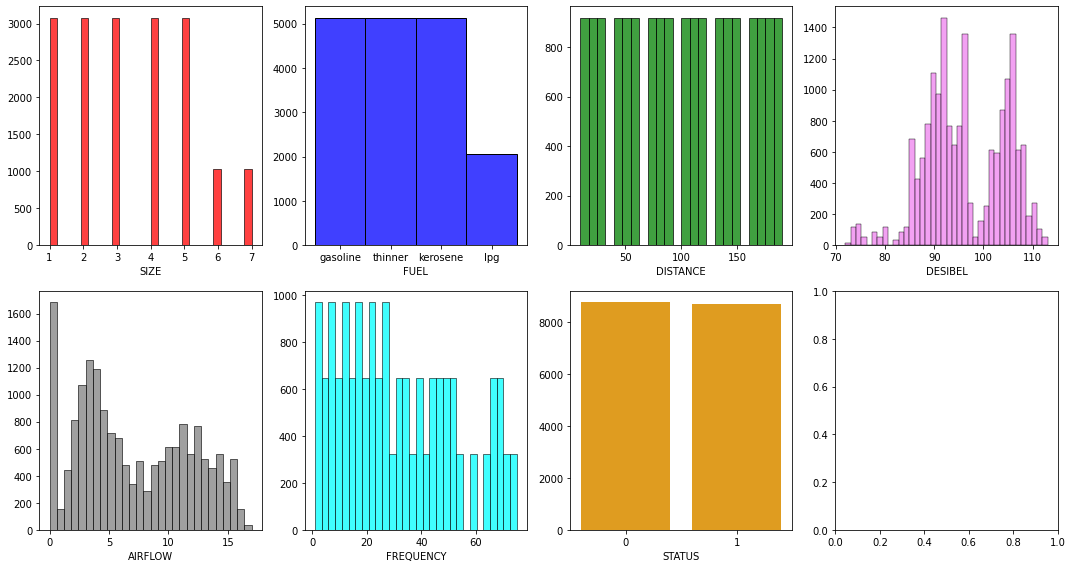

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
sns.histplot(df_analysis, x='SIZE', bins='auto', color='red', stat='count', ax=axs[0, 0])
sns.histplot(df, x='FUEL', bins='auto', color='blue', stat='count', ax=axs[0, 1])
sns.histplot(df_analysis, x='DISTANCE', bins='auto', color='green', stat='count', ax=axs[0, 2])
sns.histplot(df_analysis, x='DESIBEL', bins='auto', color='violet', stat='count', ax=axs[0, 3])
sns.histplot(df_analysis, x='AIRFLOW', bins='auto', color='gray', stat='count', ax=axs[1, 0])
sns.histplot(df_analysis, x='FREQUENCY', bins='auto', color='cyan', stat='count', ax=axs[1, 1])
sns.countplot(data=df_analysis, x='STATUS', color='orange', ax=axs[1, 2])

# Remove os labels y (Count)
for ax_row in axs:
    for ax in ax_row:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

## **Legenda**

SIZE: Tamanho da lata de combustível usada para atingir tamanhos diferentes de chamas nos experimentos;
- Combustível líquido --> 1 = 7cm, 2 = 12cm, 3 = 14cm, 4 = 16cm, 5 = 20cm;
- Gás --> 6 = "meio-gás", 7 = "gás total".

FUEL: Tipo de combustível;
- Gasolina, Solvente, Querosene, Gás LPG.

DISTANCE: Distância entre o dispositivo e as chamas;
- 10 a 190 cm. Com incrementos de 10 em 10.

DESIBEL: Intensidade sonora em decibéis (dB);
- 72 a 113 dB.

AIRFLOW: Medição do fluxo de ar, resultante das ondas sonoras, em metros por segundo (m/s);
- 0 a 17m/s.

FREQUENCY: Frequência da onda sonora em Hertz (Hz);
- 1 a 75 Hz.

STATUS: Indica o estado de extinção das chamas;
- 0 = não extinção, 1 = extinção.



# **Pré-processamento**

## **Separação das colunas em listas**

In [29]:
TARGET = 'STATUS'
CATEGORY_FT = ['FUEL']
NUMERICAL_FT = [col for col in df.columns if (col not in CATEGORY_FT) and (col != TARGET)]
FEATURES = CATEGORY_FT + NUMERICAL_FT
COLS = df.columns.tolist()

## **Divisão em previsores (X) e alvo (y)**

In [30]:
X = df[FEATURES]
y = df[TARGET]

## **Transformação e Escalonamento via Pipeline**

In [31]:
def create_pipeline(model: Any, params: Dict[str, Union[None, int, float, str, bool, Tuple[int]]] = {}, keras: bool = False) -> Pipeline:
    """Criar um pipeline para padronizar transformações dos dados e criação dos modelos.

    Args:
        model (Any): Modelo usado para as previsões.
        params (Dict[str, Union[None, int, float, str, bool, Tuple[int]]], optional): Dicionário com os parâmetros do modelo. 
        Defaults to {}.
        keras (bool, optional): "True" para pipeline de um modelo Keras e "False" para outros
        modelos. Defaults to False.

    Returns:
        Pipeline: Pipeline usado para as previsões.
    """

    categorical_encoder = ce.OneHotEncoder(cols=CATEGORY_FT, use_cat_names=True)
    numerical_pipe = make_pipeline(MinMaxScaler())

    preprocessing = ColumnTransformer(
        [
            ("cat", categorical_encoder, CATEGORY_FT),
            ("num", numerical_pipe, NUMERICAL_FT),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False,
    )

    if keras:
        pipeline = Pipeline(
        [
            ("preprocess", preprocessing),
            ("classifier", model),
        ]
    )
    else:
        pipeline = Pipeline(
            [
                ("preprocess", preprocessing),
                ("classifier", model(**params)),
            ]
        )

    return pipeline

## **Definição do método de Validação Cruzada**

In [32]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## **Definição das funções**

In [33]:
def get_pipeline_gscv_results(grid_search: GridSearchCV) -> Dict[str, Union[None, int, float, str, bool, Tuple[int]]]:
    """Obter os melhores parâmetros e resultados do GridSearchCV com pipeline.

    Args:
        grid_search (GridSearchCV): GridSearchCV usado para treinamento do modelo.

    Returns:
        Dict[str, Union[None, int, float, str, bool, Tuple[int]]]: Dicionário com os melhores parâmetros do modelo.
    """

    target_metric = 'mean_test_accuracy'

    best_params = grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_[target_metric])]
    accuracy = grid_search.cv_results_['mean_test_accuracy'][np.argmax(grid_search.cv_results_[target_metric])]
    precision = grid_search.cv_results_['mean_test_precision'][np.argmax(grid_search.cv_results_[target_metric])]
    recall = grid_search.cv_results_['mean_test_recall'][np.argmax(grid_search.cv_results_[target_metric])]
    f1 = grid_search.cv_results_['mean_test_f1'][np.argmax(grid_search.cv_results_[target_metric])]
    roc_auc = grid_search.cv_results_['mean_test_roc_auc'][np.argmax(grid_search.cv_results_[target_metric])]

    print(f'Principal métrica: {target_metric}\n')

    best_params_ = {}
    print(f'Melhores parâmetros: ')
    for k, i in best_params.items():
        k = k[12:]
        best_params_[k] = i
        print(f'\t{k}={i}')
    print('Melhores métricas:')
    print(f'\tAcurácia: {accuracy * 100.0:.2f}%')
    print(f'\tPrecisão: {precision * 100.0:.2f}%')
    print(f'\tRecall: {recall * 100.0:.2f}%')
    print(f'\tF1: {f1 * 100.0:.2f}%')
    print(f'\tROC-AUC: {roc_auc * 100.0:.2f}%')

    return best_params_

In [34]:
def print_best_results(params: Dict[str, Union[None, int, float, str, bool, Tuple[int]]], metrics: List[float]) -> None:
    """Imprimir os melhores parâmetros e métricas de desempenho do modelo.

    Args:
        params (Dict[str, Union[None, int, float, str, bool, Tuple[int]]]): Dicionário com os parâmetros do modelo.
        metrics (List[float]): Lista com as métricas de desempenho do modelo.

    Returns:
        None
    """

    accuracy = metrics[0]
    precision = metrics[1]
    recall = metrics[2]
    f1 = metrics[3]
    roc_auc = metrics[4]

    print(f'Principal métrica: Acurácia')

    print('\nMelhores parâmetros: ')
    for k, i in params.items():
        print(f'\t{k}={i}')
    print('\nMelhores métricas:')
    print(f'\tAcurácia: {accuracy * 100.0:.2f}%')
    print(f'\tPrecisão: {precision * 100.0:.2f}%')
    print(f'\tRecall: {recall * 100.0:.2f}%')
    print(f'\tF1: {f1 * 100.0:.2f}%')
    print(f'\tROC-AUC: {roc_auc * 100.0:.2f}%')

In [35]:
def plot_confusion_matrix(y_test: np.ndarray, y_pred: np.ndarray) -> None:
    """Plotar a matriz de confusão das previsões dos modelos.

    Args:
        y_test (np.ndarray): Array com os dados de teste.
        y_pred (np.ndarray): Array com as previsões.

    Returns:
        None
    """

    cm = confusion_matrix(y_test, y_pred)
    cmn = confusion_matrix(y_test, y_pred, normalize='true')
    cms = [cm, cmn]
    for i, conf_matrix in enumerate(cms):
        class_names = ['0', '1']
        plt.figure(figsize=(4, 3))
        if i == 0:
            fmt = 'd'
            plt.title('Matriz de Confusão')
        else:
            fmt = '.2f'
            plt.title('Matriz de Confusão Normalizada')
        sns.heatmap(conf_matrix, annot=True,fmt=fmt, cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Previsto')
        plt.ylabel('Verdadeiro')
        plt.show()
        print()

In [36]:
def plot_roc_auc_cv_curve(X: pd.DataFrame, y: pd.Series, model: Any,
                          params: Dict[str, Union[None, int, float, str, bool, Tuple[int]]], 
                          cv: StratifiedKFold) -> None:
    """Plotar o gráficp com a curva ROC-AUC pela validação cruzada.

    Args:
        X (pd.DataFrame): DataFrame com os previsores.
        y (pd.Series): Série com os alvos.
        model (Any): Modelo usado para as previsões.
        params (Dict[str, Union[None, int, float, str, bool, Tuple[int]]]): Dicionário com os 
        parâmetros do modelo.
        cv (StratifiedKFold): Splitter da validação cruzada.

    Returns:
        None
    """

    classifier = create_pipeline(model, params)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        X_train = df.iloc[train, :-1]
        y_train = df.iloc[train, -1]
        X_test = df.iloc[test, :-1]
        y_test = df.iloc[test, -1]

        classifier.fit(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == len(list(cv.split(X, y))) - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label '{1}')",
    )

    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

In [37]:
def get_optuna_study(objective_func: Callable, trials: int,
                     multiple_directions: bool = True) -> optuna.Study:
    """Obter estudo da otimização do optuna.

    Args:
        objective (Callable): Função objetiva.
        trials (int): Número de experimentos do estudo.
        multiple_directions (bool): "True" para usar múltiplas direções e
        "False" para usar apenas uma direção.

    Returns:
        optuna.Study: Estudo da otimização do optuna.
    """

    if multiple_directions:
        study = optuna.create_study(
            directions=['maximize', 'maximize', 'maximize', 'maximize', 'maximize'],
            sampler=optuna.samplers.TPESampler(
                seed=42, multivariate=True, warn_independent_sampling=False
            ),
        )
    else:
         study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(
                seed=42, multivariate=True, warn_independent_sampling=False
            ),
        )

    study.optimize(objective_func, n_trials=trials)

    return study

In [38]:
def get_best_trial_results(study: optuna.Study, metric_idx: int) -> \
    Dict[str, Union[Dict[str, Union[None, int, float, str, bool, Tuple[int]]], List[float]]]:
    """Obter os parâmetros e as métricas do melhor experimento do estudo do optuna.

    Args:
        study (optuna.Study): Estudo da otimização do optuna.
        metric_idx (int): Índice da métrica principal.

    Returns:
        Dict[str, Union[Dict[str, Union[None, int, float, str, bool, Tuple[int]]], List[float]]]: 
        Tupla com os parâmetros e as métricas de desempenho do melhor experimento do estudo do optuna.
    """

    trial_with_highest_metric = max(study.best_trials, key=lambda t: t.values[metric_idx])

    params = trial_with_highest_metric.params
    trial_acc = trial_with_highest_metric.values[0]
    trial_precision = trial_with_highest_metric.values[1]
    trial_recall = trial_with_highest_metric.values[2]
    trial_f1 = trial_with_highest_metric.values[3]
    trial_roc_auc = trial_with_highest_metric.values[4]

    return {
        'params': params,
        'trial_metrics': [trial_acc, trial_precision, trial_recall, trial_f1, trial_roc_auc]
    }

In [39]:
def build_keras_model_optuna(trial: Any, X: np.ndarray)-> Sequential:
    """Criar um modelo Sequencial do Keras para ser otimizado pelo optuna.

    Args:
        trial (Any): Experimento do estudo optuna.
        X (np.ndarray): Array com os dados previsores.

    Returns:
        Sequential:  Modelo Sequencial do Keras otimizado pelo
        optuna.
    """

    n_input = len(X[0])
    n_output = 1
    min_num_hidden = 1
    max_num_hidden = 2*n_input/3 + n_output
    model = Sequential()
    model.add(Input(shape=(n_input,)))
    n_layers = trial.suggest_int('n_layers', 1, 2)
    for i in range(1, n_layers+1):
        num_hidden = trial.suggest_int(f'n_units_l{i}', min_num_hidden, max_num_hidden)
        model.add(Dense(num_hidden, activation='relu'))
        dropout = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5, step=0.1)
        model.add(Dropout(rate=dropout))
    model.add(Dense(n_output, activation='sigmoid'))

    lr = trial.suggest_float('learning_rate', 1e-05, 1e-01, log=True)
    opt_name = trial.suggest_categorical('optimizer_name', ['adam', 'rmsprop'])
    if opt_name == 'adam':
        optimizer = Adam(learning_rate=lr)
    if opt_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

In [40]:
def build_keras_model(n_input: int,
                      n_layers: int,
                      hidden_layers_details: Dict[int, List[Union[int, str]]],
                      n_output: int,
                      out_l_act_func: str,
                      optimizer: Union[Adam, RMSprop],
                      loss_function: str = 'binary_crossentropy',
                      metrics: List[str] = ['accuracy']) -> Sequential:
    """Construir modelo Sequencial usando camadas do Tensorflow/Keras.

    Args:
        n_input (int): Quantidade de neurônios da camada de entrada.
        n_layers (int): Quantidade de camadas ocultas.
        hidden_layers_details (Dict[int, List[Union[int, str]]]): Dicionário com os
        detalhes de cada camada oculta.
        n_output (int): Quantidade de neurônios da camada de saída.
        out_l_act_func (str): Função de ativação da camada de saída.
        optimizer (Union[Adam, RMSprop]): Otimizador para compilar o modelo.
        loss_function (str, optional): Função de perda para compilar o modelo.
        Defaults to 'binary_crossentropy'.
        metrics (List[str], optional): Lista com as métricas de desempenho para compilar
        o modelo. Defaults to ['accuracy'].

    Returns:
        Sequential: Modelo Sequencial do Keras.
    """

    model = Sequential()
    model.add(Input(shape=(n_input,)))
    for i in range(1,n_layers+1):
        num_hidden = hidden_layers_details[i][0]
        act_func_hidden = hidden_layers_details[i][1]
        dropout = hidden_layers_details[i][2]
        model.add(Dense(num_hidden, activation=act_func_hidden))
        model.add(Dropout(dropout))
    model.add(Dense(n_output, activation=out_l_act_func))
    model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

    return model

**Métricas de desempenho disponíveis**

In [41]:
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 '

# **Classificação - Modelos Comuns**

## **1-NN (1-Nearest Neighbor)**

In [42]:
params = {
    'n_neighbors': 1,
    'n_jobs': -1
}

### **Sem a biblioteca scikit-learn**

In [43]:
# Transformação de variáveis categóricas
encoder = ce.OneHotEncoder(cols=CATEGORY_FT, use_cat_names=True)
X_ = encoder.fit_transform(X, y)

# Transformação em arrays
X_ = X_.values

X_train, X_test, y_train, y_test = train_test_split(X_, y, stratify=y, test_size=0.2,
                                                        shuffle=True, random_state=42)

In [44]:
# Converter as séries de entrada em matrizes NumPy para facilitar as operações
y_train = np.array(y_train)
y_test = np.array(y_test)

# Calcular as distâncias de todos os pontos em X_test para todos os pontos em X_train
dists = np.linalg.norm(X_train[:, np.newaxis] - X_test, axis=2)

# Encontrar o índice do valor mínimo em cada linha de dists
min_indices = np.argmin(dists, axis=0)

# Usar os índices mínimos para obter os valores correspondentes em y_train
preds = y_train[min_indices]

# Calcular a acurácia
hits = np.sum(y_test.ravel() == preds.ravel())
total = len(preds)
print(f'Acurácia: {(hits / total) * 100.0:.2f}%')

Acurácia: 89.74%


### **Com a biblioteca scikit-learn**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,
                                                    shuffle=True, random_state=42)

y_train = y_train.values
y_test = y_test.values

In [46]:
model = create_pipeline(KNeighborsClassifier, params)
model.fit(X_train, y_train)
preds = model.predict(X_test)

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)

print(f'Acurácia: {(accuracy) * 100.0:.2f}%')
print(f'Precisão: {(precision) * 100.0:.2f}%')
print(f'Recall: {(recall) * 100.0:.2f}%')
print(f'F1: {(f1) * 100.0:.2f}%')
print(f'ROC-AUC: {(roc_auc) * 100.0:.2f}%')

Acurácia: 96.30%
Precisão: 96.53%
Recall: 96.03%
F1: 96.28%
ROC-AUC: 96.30%


### **Matriz de Confusão**

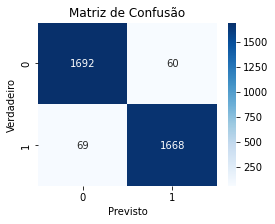

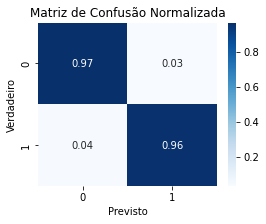

In [47]:
plot_confusion_matrix(y_test, preds)

### **Validação Cruzada**

In [48]:
model = create_pipeline(KNeighborsClassifier, params)
scores = cross_validate(model, X, y,  scoring=['accuracy', 'precision',
                                               'recall', 'f1', 'roc_auc'],
                        cv=cv, n_jobs=-1)
accuracy = scores['test_accuracy']
precision = scores['test_precision']
recall = scores['test_recall']
f1 = scores['test_f1']
roc_auc = scores['test_roc_auc']

print('Acurácias em cada fold: ')
for i, score in enumerate(accuracy):
    print(f'\tFold {i} --> {score * 100:.2f}%')
print(f'\nAcurácia Média: {accuracy.mean() * 100:.2f}%')
print(f'Precisão Média: {precision.mean() * 100:.2f}%')
print(f'Recall Médio: {recall.mean() * 100:.2f}%')
print(f'F1 Médio: {f1.mean() * 100:.2f}%')
print(f'ROC-AUC Médio: {roc_auc.mean() * 100:.2f}%')

Acurácias em cada fold: 
	Fold 0 --> 96.79%
	Fold 1 --> 96.79%
	Fold 2 --> 96.62%
	Fold 3 --> 97.25%
	Fold 4 --> 96.96%
	Fold 5 --> 97.02%
	Fold 6 --> 96.33%
	Fold 7 --> 96.96%
	Fold 8 --> 95.70%
	Fold 9 --> 95.99%

Acurácia Média: 96.64%
Precisão Média: 96.60%
Recall Médio: 96.66%
F1 Médio: 96.63%
ROC-AUC Médio: 96.64%


### **Curva ROC-AUC**

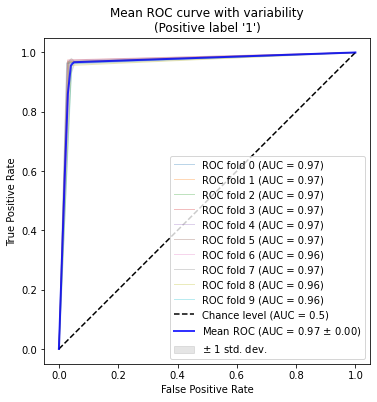

In [49]:
plot_roc_auc_cv_curve(X, y, KNeighborsClassifier, params, cv)

## **K-NN (K-Nearest Neighbors)**

### **Otimização de Hiperparâmetros com Optuna**

In [50]:
def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 29, 2),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski', 'chebyshev']),
        'p': trial.suggest_int('p', 1, 4),
        'leaf_size': trial.suggest_int('leaf_size', 20, 40),
        'n_jobs': -1,
    }

    knn = create_pipeline(KNeighborsClassifier, params)
    scores = cross_validate(knn, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=-1)
    accuracy = scores['test_accuracy'].mean()
    precision = scores['test_precision'].mean()
    recall = scores['test_recall'].mean()
    f1 = scores['test_f1'].mean()
    roc_auc = scores['test_roc_auc'].mean()

    return accuracy, precision, recall, f1, roc_auc

study = get_optuna_study(objective, 50)

[I 2024-02-17 09:38:20,989] A new study created in memory with name: no-name-b1387488-54ab-44e9-83c8-baaf70ff0dfa
[I 2024-02-17 09:38:23,824] Trial 0 finished with values: [0.9621028298414869, 0.9615967670184553, 0.962340313830718, 0.9619548150529349, 0.9949089976164893] and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean', 'p': 4, 'leaf_size': 32}. 
[I 2024-02-17 09:38:24,511] Trial 1 finished with values: [0.963994933098499, 0.9636542299797352, 0.9640676289818796, 0.9638488071554814, 0.9957868050227849] and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'leaf_size': 31}. 
[I 2024-02-17 09:38:25,054] Trial 2 finished with values: [0.9611850371967089, 0.9598351034713624, 0.962340313830718, 0.9610713282628076, 0.994757956349741] and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'chebyshev', 'p': 4, 'leaf_size': 24}. 
[I 2024-02-17 09:38:25,894] Trial 3 finished with values: [0.9549931652690518, 0.953117

In [51]:
knn_results = get_best_trial_results(study, 0)
best_params_knn, metrics_knn = knn_results['params'], knn_results['trial_metrics']
print_best_results(best_params_knn, metrics_knn)

Principal métrica: Acurácia

Melhores parâmetros: 
	n_neighbors=5
	weights=distance
	metric=manhattan
	p=2
	leaf_size=25

Melhores métricas:
	Acurácia: 97.05%
	Precisão: 97.22%
	Recall: 96.86%
	F1: 97.03%
	ROC-AUC: 99.59%


### **Matriz de Confusão**

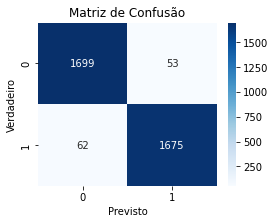

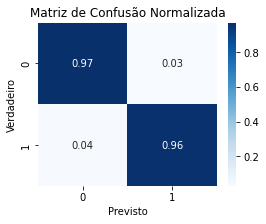

In [52]:
knn = create_pipeline(KNeighborsClassifier, best_params_knn)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
plot_confusion_matrix(y_test, preds)

### **Curva ROC-AUC**

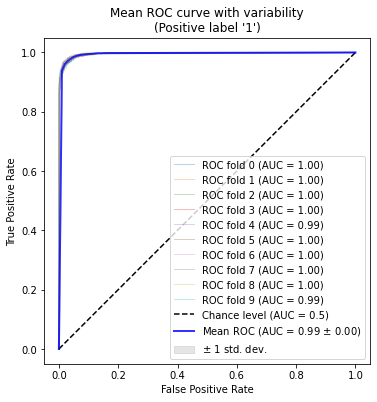

In [53]:
plot_roc_auc_cv_curve(X, y, KNeighborsClassifier, best_params_knn, cv)

## **Naive Bayes**

In [54]:
SCORING = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

### **Gaussian**

Trabalha melhor com dados reais (float).

#### **GridSearchCV**

In [55]:
param_grid = {
    'classifier__var_smoothing': np.logspace(0,-9, num=100),
}

gs_NB = create_pipeline(GaussianNB)

grid_search = GridSearchCV(gs_NB, param_grid, scoring=SCORING, cv=cv, n_jobs=-1, refit=False)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(cols=['FUEL'],
                                                                                       use_cat_names=True),
                                                                         ['FUEL']),
                                                                        ('num',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['SIZE',
                                                                          'DISTANCE',
                                                                          'DESIBEL',
                                                                          'AIRFLOW',
                                                                          'FREQUENCY'])],
                                                          verb...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             refit=False,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [56]:
best_params_gsnb = get_pipeline_gscv_results(grid_search)

Principal métrica: mean_test_accuracy

Melhores parâmetros: 
	var_smoothing=0.657933224657568
Melhores métricas:
	Acurácia: 87.79%
	Precisão: 90.18%
	Recall: 84.71%
	F1: 87.35%
	ROC-AUC: 95.53%


#### **Matriz de Confusão**

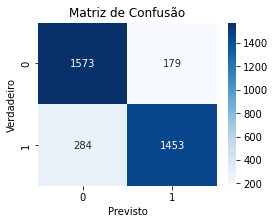

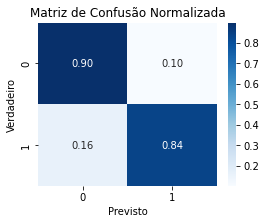

In [57]:
gs_NB = create_pipeline(GaussianNB, best_params_gsnb)
gs_NB.fit(X_train, y_train)
preds = gs_NB.predict(X_test)
plot_confusion_matrix(y_test, preds)

#### **Curva ROC-AUC**

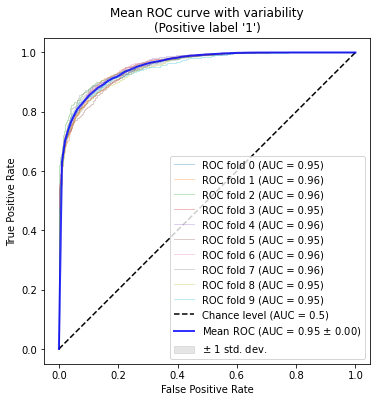

In [58]:
plot_roc_auc_cv_curve(X, y, GaussianNB, best_params_gsnb, cv)

### **Multinomial**

Trabalha melhor com dados inteiros.

#### **GridSearchCV**

In [59]:
param_grid = {
    'classifier__alpha': [0.0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
}

mt_NB = create_pipeline(MultinomialNB)

grid_search = GridSearchCV(mt_NB, param_grid, scoring=SCORING, cv=cv, n_jobs=-1, refit=False)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(cols=['FUEL'],
                                                                                       use_cat_names=True),
                                                                         ['FUEL']),
                                                                        ('num',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['SIZE',
                                                                          'DISTANCE',
                                                                          'DESIBEL',
                                                                          'AIRFLOW',
                                                                          'FREQUENCY'])],
                                                          verbose_feature_names_out=False)),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.0, 0.001, 0.01, 0.05, 0.1, 0.5,
                                               1.0, 2.0, 5.0, 10.0]},
             refit=False,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [60]:
best_params_mtnb = get_pipeline_gscv_results(grid_search)

Principal métrica: mean_test_accuracy

Melhores parâmetros: 
	alpha=5.0
Melhores métricas:
	Acurácia: 87.59%
	Precisão: 89.56%
	Recall: 84.98%
	F1: 87.21%
	ROC-AUC: 95.30%


#### **Matriz de Confusão**

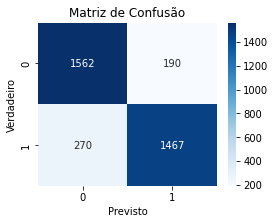

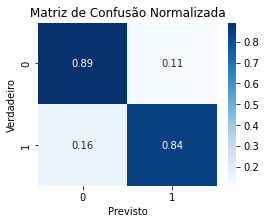

In [61]:
mt_NB = create_pipeline(MultinomialNB, best_params_mtnb)
mt_NB.fit(X_train, y_train)
preds = mt_NB.predict(X_test)
plot_confusion_matrix(y_test, preds)

#### **Curva ROC-AUC**

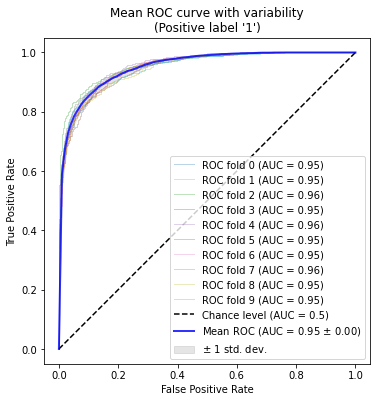

In [62]:
plot_roc_auc_cv_curve(X, y, MultinomialNB, best_params_mtnb, cv)

### **Bernoulli**

Trabalha melhor com dados binários.

#### **GridSearchCV**

In [63]:
param_grid = {
    'classifier__alpha': [0.0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'classifier__binarize': [None, 1.0, 2.0, 5.0, 8.5, 10.0]
}

bn_NB = create_pipeline(BernoulliNB)

grid_search = GridSearchCV(bn_NB, param_grid, scoring=SCORING, cv=cv, n_jobs=-1, refit=False)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(cols=['FUEL'],
                                                                                       use_cat_names=True),
                                                                         ['FUEL']),
                                                                        ('num',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['SIZE',
                                                                          'DISTANCE',
                                                                          'DESIBEL',
                                                                          'AIRFLOW',
                                                                          'FREQUENCY'])],
                                                          verbose_feature_names_out=False)),
                                       ('classifier', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.0, 0.001, 0.01, 0.05, 0.1, 0.5,
                                               1.0, 2.0, 5.0, 10.0],
                         'classifier__binarize': [None, 1.0, 2.0, 5.0, 8.5,
                                                  10.0]},
             refit=False,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [64]:
best_params_bnnb = get_pipeline_gscv_results(grid_search)

Principal métrica: mean_test_accuracy

Melhores parâmetros: 
	alpha=10.0
	binarize=None
Melhores métricas:
	Acurácia: 87.56%
	Precisão: 89.50%
	Recall: 84.99%
	F1: 87.19%
	ROC-AUC: 95.35%


#### **Matriz de Confusão**

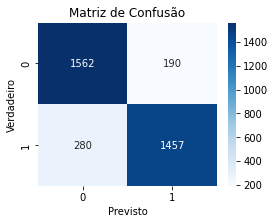

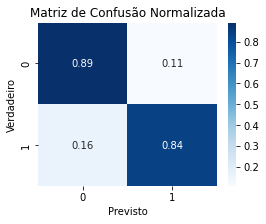

In [65]:
bn_NB = create_pipeline(BernoulliNB, best_params_bnnb)
bn_NB.fit(X_train, y_train)
preds = bn_NB.predict(X_test)
plot_confusion_matrix(y_test, preds)

#### **Curva ROC-AUC**

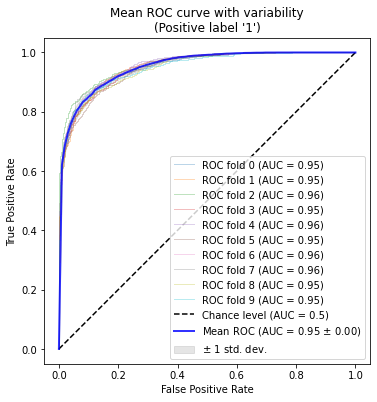

In [66]:
plot_roc_auc_cv_curve(X, y, BernoulliNB, best_params_bnnb, cv)

## **Resultados**

1º: K-NN(n_neighbors=5, 'weights'='distance', metric='manhattan', p=2, leaf_size=25)

	Acurácia: 97.05%
	Precisão: 97.22%
	Recall: 96.86%
	F1: 97.03%
	ROC-AUC: 99.59%

2º: 1-NN(n_nighbours=1)

    Acurácia: 96.64%
    Precisão: 96.60%
    Recall: 96.66%
    F1: 96.63%
	ROC-AUC: 96.64%

3º: GaussianNB(var_smoothing=0.657933224657568)

	Acurácia: 87.79%
	Precisão: 90.18%
	Recall: 84.71%
	F1: 87.35%
	ROC-AUC: 95.53%

4º: MultinomialNB(alpha=5.0)

	Acurácia: 87.59%
	Precisão: 89.56%
	Recall: 84.98%
	F1: 87.21%
	ROC-AUC: 95.30%

5º: BernoulliNB(alpha=10.0, binarize=None)

	Acurácia: 87.56%
	Precisão: 89.50%
	Recall: 84.99%
	F1: 87.19%
	ROC-AUC: 95.35%

# **Classificação - Redes Neurais Artificiais**

## **MLPClassifier**

In [67]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,
                                                    shuffle=True, random_state=42)

### **1 Camada Oculta**

In [69]:
def objective(trial):
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(x,) for x in range(1,8)]),
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['sgd', 'adam']),
        'alpha': trial.suggest_float("alpha", 1e-5, 0.3, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-3, 1e-1, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 200, step=20),
        'early_stopping': True,
        'validation_fraction': 0.2,
        'random_state': 42
    }

    mlp = create_pipeline(MLPClassifier, params)
    scores = cross_validate(mlp, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                            cv=cv, n_jobs=-1)
    accuracy = scores['test_accuracy'].mean()
    precision = scores['test_precision'].mean()
    recall = scores['test_recall'].mean()
    f1 = scores['test_f1'].mean()
    roc_auc = scores['test_roc_auc'].mean()

    return accuracy, precision, recall, f1, roc_auc

study = get_optuna_study(objective, 50)

[I 2024-02-17 09:39:27,969] A new study created in memory with name: no-name-249b2204-16b0-4317-a787-6ccb4ba1ee66
[I 2024-02-17 09:39:31,604] Trial 0 finished with values: [0.8978897347001886, 0.9044982869515223, 0.8887479383664433, 0.8965268643165137, 0.9676367502745554] and parameters: {'hidden_layer_sizes': (2,), 'activation': 'identity', 'solver': 'sgd', 'alpha': 8.926227381843726e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01120760621186057, 'max_iter': 140}. 
[I 2024-02-17 09:39:35,408] Trial 1 finished with values: [0.6357068438137032, 0.6176161939590665, 0.704482633456943, 0.6581371755811305, 0.7362474582481044] and parameters: {'hidden_layer_sizes': (7,), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 1.9554371852085012e-05, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0040665633135147945, 'max_iter': 100}. 
[I 2024-02-17 09:39:36,801] Trial 2 finished with values: [0.8966856194080559, 0.9048472686760964, 0.8858674356356411, 0.89504586689766, 0.9673903

#### **Métricas de Desempenho**

In [70]:
mlp1_results = get_best_trial_results(study, 0)
best_params_mlp1, metrics_mlp1 = mlp1_results['params'], mlp1_results['trial_metrics']
print_best_results(best_params_mlp1, metrics_mlp1)

Principal métrica: Acurácia

Melhores parâmetros: 
	hidden_layer_sizes=(7,)
	activation=tanh
	solver=adam
	alpha=0.00010576869105669781
	learning_rate=invscaling
	learning_rate_init=0.0723427984566542
	max_iter=180

Melhores métricas:
	Acurácia: 94.58%
	Precisão: 94.85%
	Recall: 94.23%
	F1: 94.53%
	ROC-AUC: 99.01%


#### **Matriz de Confusão**

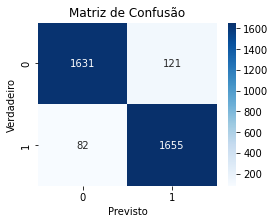

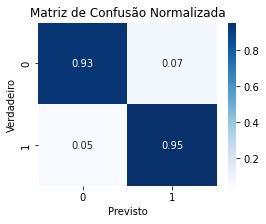

In [71]:
mlp1 = create_pipeline(MLPClassifier, best_params_mlp1)
mlp1.fit(X_train, y_train)
preds = mlp1.predict(X_test)
plot_confusion_matrix(y_test, preds)

#### **Curva ROC-AUC**

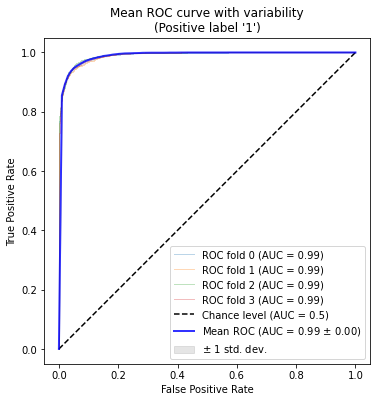

In [72]:
plot_roc_auc_cv_curve(X, y, MLPClassifier, best_params_mlp1, cv)

### **2 Camadas Ocultas**

In [73]:
def objective(trial):
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes',
                                                        [(x,y) for x in range(1,8) for y in range(1,8)]),
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['sgd', 'adam']),
        'alpha': trial.suggest_float("alpha", 1e-5, 0.3, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-3, 1e-1, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 200, step=20),
        'early_stopping': True,
        'validation_fraction': 0.2,
        'random_state': 42
    }

    mlp = create_pipeline(MLPClassifier, params)
    scores = cross_validate(mlp, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                            cv=cv, n_jobs=-1)
    accuracy = scores['test_accuracy'].mean()
    precision = scores['test_precision'].mean()
    recall = scores['test_recall'].mean()
    f1 = scores['test_f1'].mean()
    roc_auc = scores['test_roc_auc'].mean()

    return accuracy, precision, recall, f1, roc_auc

study = get_optuna_study(objective, 50)

[I 2024-02-17 09:41:26,534] A new study created in memory with name: no-name-c56107f5-b28a-4818-bfd0-a35493670d27
[I 2024-02-17 09:41:27,370] Trial 0 finished with values: [0.5021786492661182, 0.0, 0.0, 0.0, 0.2837123104820984] and parameters: {'hidden_layer_sizes': (2, 5), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.1340734336194926, 'learning_rate': 'invscaling', 'learning_rate_init': 0.004473636174621266, 'max_iter': 140}. 
[I 2024-02-17 09:41:28,613] Trial 1 finished with values: [0.8988642949706426, 0.9032057250306103, 0.8925475528913814, 0.8978132795744642, 0.9683355918490477] and parameters: {'hidden_layer_sizes': (2, 2), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.03964033694082833, 'learning_rate': 'invscaling', 'learning_rate_init': 0.04119839624605188, 'max_iter': 200}. 
[I 2024-02-17 09:41:33,897] Trial 2 finished with values: [0.9269573250390765, 0.9324116373431502, 0.9199588416219671, 0.9261379009434886, 0.9839437457671545] and parameters: {'hidden_layer_

#### **Métricas de Desempenho**

In [74]:
results_mlp2 = get_best_trial_results(study, 0)
best_params_mlp2, metrics_mlp2 = results_mlp2['params'], results_mlp2['trial_metrics']
print_best_results(best_params_mlp2, metrics_mlp2)

Principal métrica: Acurácia

Melhores parâmetros: 
	hidden_layer_sizes=(7, 1)
	activation=logistic
	solver=adam
	alpha=0.0003129615673880955
	learning_rate=adaptive
	learning_rate_init=0.08646715415971704
	max_iter=100

Melhores métricas:
	Acurácia: 94.58%
	Precisão: 94.53%
	Recall: 94.65%
	F1: 94.56%
	ROC-AUC: 99.12%


#### **Matriz de Confusão**

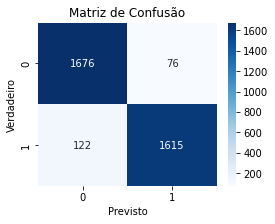

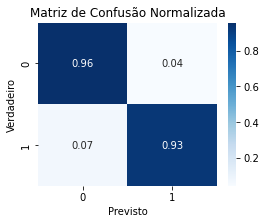

In [75]:
mlp2 = create_pipeline(MLPClassifier, best_params_mlp2)
mlp2.fit(X_train, y_train)
preds = mlp2.predict(X_test)
plot_confusion_matrix(y_test, preds)

#### **Curva ROC-AUC**

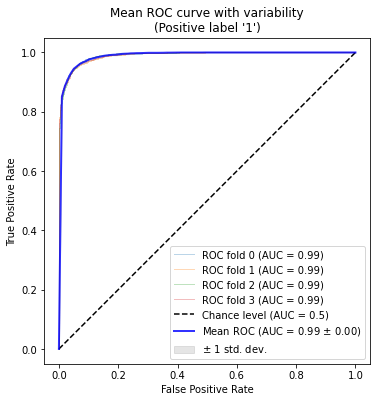

In [76]:
plot_roc_auc_cv_curve(X, y, MLPClassifier, best_params_mlp2, cv)

## **Keras**

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,
                                                    shuffle=True, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2,
                                                  shuffle=True, random_state=42)

categorical_encoder = ce.OneHotEncoder(cols=CATEGORY_FT, use_cat_names=True)

column_trasformer = ColumnTransformer(
    [
        ("cat", categorical_encoder, CATEGORY_FT),
        ("num", MinMaxScaler(), NUMERICAL_FT),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

X_train = column_trasformer.fit_transform(X_train)
X_val = column_trasformer.transform(X_val)
X_test = column_trasformer.transform(X_test)

y_train = y_train.values.reshape(-1,1)
y_val = y_val.values.reshape(-1,1)
y_test = y_test.values

In [78]:
def objective(trial):
    batch_size = trial.suggest_int('batch_size', 32, 256, step=32)
    epochs = trial.suggest_int('epochs', 10, 200, step=10)

    model = build_keras_model_optuna(trial, X_train)

    with suppress_stdout():
        model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, mode='max'),
                       optuna.integration.TFKerasPruningCallback(trial, "val_accuracy")],
            epochs=epochs,
            validation_data=(X_val, y_val),
            use_multiprocessing=True
        )

        preds = model.predict(X_test).round()
    accuracy = accuracy_score(y_test, preds)

    return accuracy

study = get_optuna_study(objective, 50, False)

[I 2024-02-17 09:43:51,510] A new study created in memory with name: no-name-e190ed7d-225e-48ec-931e-7059511adfd6
[I 2024-02-17 09:43:59,204] Trial 0 finished with value: 0.9214674691888793 and parameters: {'batch_size': 96, 'epochs': 200, 'n_layers': 2, 'n_units_l1': 5, 'dropout_l1': 0.0, 'n_units_l2': 2, 'dropout_l2': 0.0, 'learning_rate': 0.029154431891537533, 'optimizer_name': 'rmsprop'}. Best is trial 0 with value: 0.9214674691888793.
[I 2024-02-17 09:44:15,009] Trial 1 finished with value: 0.8933791917454859 and parameters: {'batch_size': 32, 'epochs': 200, 'n_layers': 2, 'n_units_l1': 2, 'dropout_l1': 0.1, 'n_units_l2': 2, 'dropout_l2': 0.1, 'learning_rate': 0.0012561043700013551, 'optimizer_name': 'adam'}. Best is trial 0 with value: 0.9214674691888793.
[I 2024-02-17 09:44:19,800] Trial 2 finished with value: 0.8953854972771568 and parameters: {'batch_size': 160, 'epochs': 30, 'n_layers': 1, 'n_units_l1': 3, 'dropout_l1': 0.2, 'learning_rate': 0.013826232179369865, 'optimizer_n

In [79]:
params = study.best_trial.params

epochs = params.get('epochs', 100)
batch_size = params.get('batch_size', 64)

n_input = len(X_train[0])
n_output = 1 # Classificação binária
n_layers = params.get('n_layers', 1)

default_n_units_l = 2*n_input/3 + n_output
hidden_layers_details = {
    i: [
        params.get(f'n_units_l{i}', default_n_units_l),
        'relu',
        params.get(f'dropout_l{i}', 0.0)
    ] for i in range(1,n_layers+1)
}

lr = params.get('learning_rate', 0.001)
opt_name = params.get('optimizer_name', 'adam')
if opt_name == 'adam':
    optimizer = Adam(learning_rate=lr)
if opt_name == 'rmsprop':
    optimizer = RMSprop(learning_rate=lr)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max')]

#### **Com o conjunto de validação**

In [80]:
clf = build_keras_model(
    n_input=n_input,
    n_layers=n_layers,
    hidden_layers_details=hidden_layers_details,
    n_output=n_output,
    out_l_act_func='sigmoid', # sigmoid para classificação binária
    optimizer=optimizer,
)

clf.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/130
117/117 [==============================] - 2s 4ms/step - loss: 0.3015 - accuracy: 0.8813 - val_loss: 0.2113 - val_accuracy: 0.9111
Epoch 2/130
117/117 [==============================] - 0s 3ms/step - loss: 0.1962 - accuracy: 0.9175 - val_loss: 0.2094 - val_accuracy: 0.9061
Epoch 3/130
117/117 [==============================] - 0s 3ms/step - loss: 0.1817 - accuracy: 0.9219 - val_loss: 0.1846 - val_accuracy: 0.9233
Epoch 4/130
117/117 [==============================] - 0s 3ms/step - loss: 0.1716 - accuracy: 0.9269 - val_loss: 0.1836 - val_accuracy: 0.9176
Epoch 5/130
117/117 [==============================] - 0s 3ms/step - loss: 0.1624 - accuracy: 0.9280 - val_loss: 0.1591 - val_accuracy: 0.9337
Epoch 6/130
117/117 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9301 - val_loss: 0.1722 - val_accuracy: 0.9215
Epoch 7/130
117/117 [==============================] - 0s 3ms/step - loss: 0.1587 - accuracy: 0.9303 - val_loss: 0.1560 - val_accuracy: 0.9283

In [81]:
# weights, biases = model.layers[0].get_weights()
# print("weights",weights.size, weights, "biases", biases)
# model.summary()

##### **Métricas de desempenho**

In [82]:
preds = clf.predict(X_test).round().ravel()

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)

metrics_keras = [accuracy, precision, recall, f1, roc_auc]

print_best_results(params, metrics_keras)

110/110 [==============================] - 0s 2ms/step
Principal métrica: Acurácia

Melhores parâmetros: 
	batch_size=96
	epochs=130
	n_layers=2
	n_units_l1=7
	dropout_l1=0.0
	n_units_l2=1
	dropout_l2=0.0
	learning_rate=0.06210350612011153
	optimizer_name=adam

Melhores métricas:
	Acurácia: 90.71%
	Precisão: 86.14%
	Recall: 96.95%
	F1: 91.22%
	ROC-AUC: 90.74%


##### **Matriz de Confusão**

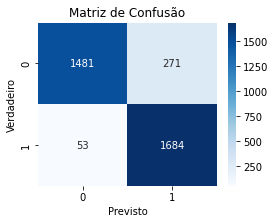

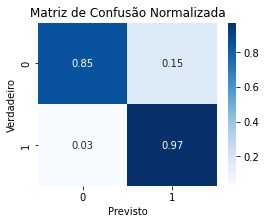

In [83]:
plot_confusion_matrix(y_test, preds)

## **Resultados**

1º: MLPClassier_1HiddenLayer(hidden_layer_sizes=(7,), activation='tanh', solver='adam', alpha=0.00010576869105669781, learning_rate='invscaling', learning_rate_init=0.0723427984566542, max_iter=180)

	Acurácia: 94.58%
	Precisão: 94.85%
	Recall: 94.23%
	F1: 94.53%
	ROC-AUC: 99.01%

2º: MLPClassier_2HiddenLayer(hidden_layer_sizes=(7,1), activation='logistic', solver='adam', alpha=0.0003129615673880955, learning_rate='adaptive', learning_rate_init=0.08646715415971704, max_iter=100)

	Acurácia: 94.58%
	Precisão: 94.53%
	Recall: 94.65%
	F1: 94.56%
	ROC-AUC: 99.12%

3º: TensorFlow/Keras(batch_size=96, epochs=130, n_layers=2, n_units_l1=7, dropout_l1=0.0, n_units_l2=1, dropout_l2=0.0, learning_rate=0.06210350612011153, optimizer_name=adam)

	Acurácia: 90.71%
	Precisão: 86.14%
	Recall: 96.95%
	F1: 91.22%
	ROC-AUC: 90.74%

# **Resultados Finais**

1º: K-NN(n_neighbors=7, 'weights'='distance', metric='manhattan', p=2, leaf_size=24)

	Acurácia: 97.03%
	Precisão: 97.19%
	Recall: 96.83%
	F1: 97.01%
	ROC-AUC: 99.64%

2º: 1-NN(n_nighbours=1)

    Acurácia: 96.64%
    Precisão: 96.60%
    Recall: 96.66%
    F1: 96.63%
	ROC-AUC: 96.64%

3º: MLPClassier_1HiddenLayer(hidden_layer_sizes=(7,), activation='tanh', solver='adam', alpha=0.00010576869105669781, learning_rate='invscaling', learning_rate_init=0.0723427984566542, max_iter=180)

	Acurácia: 94.58%
	Precisão: 94.85%
	Recall: 94.23%
	F1: 94.53%
	ROC-AUC: 99.01%

4º: MLPClassier_2HiddenLayer(hidden_layer_sizes=(7,1), activation='logistic', solver='adam', alpha=0.0003129615673880955, learning_rate='adaptive', learning_rate_init=0.08646715415971704, max_iter=100)

	Acurácia: 94.58%
	Precisão: 94.53%
	Recall: 94.65%
	F1: 94.56%
	ROC-AUC: 99.12%

5º: TensorFlow/Keras(batch_size=96, epochs=130, n_layers=2, n_units_l1=7, dropout_l1=0.0, n_units_l2=1, dropout_l2=0.0, learning_rate=0.06210350612011153, optimizer_name=adam)

	Acurácia: 90.71%
	Precisão: 86.14%
	Recall: 96.95%
	F1: 91.22%
	ROC-AUC: 90.74%

6º: GaussianNB(var_smoothing=0.657933224657568)

	Acurácia: 87.79%
	Precisão: 90.18%
	Recall: 84.71%
	F1: 87.35%
	ROC-AUC: 95.53%

7º: MultinomialNB(alpha=5.0)

	Acurácia: 87.59%
	Precisão: 89.56%
	Recall: 84.98%
	F1: 87.21%
	ROC-AUC: 95.30%

8º: BernoulliNB(alpha=10.0, binarize=None)

	Acurácia: 87.56%
	Precisão: 89.50%
	Recall: 84.99%
	F1: 87.19%
	ROC-AUC: 95.35%